In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

## 1. Data (preparing and loading)

In [2]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [3]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets

In [4]:
train_split = int(0.8 * len(X))
X_train , y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [5]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    plt.figure(figsize=(10,7))

    # Plot training data in red
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Test data")

    if predictions is not None:
        # Plot the predictions if they exist
        plt.scatter(test_data, predictions, c= "r", s=4, label="Predictions")
    
    plt.legend(prop={"size": 14})

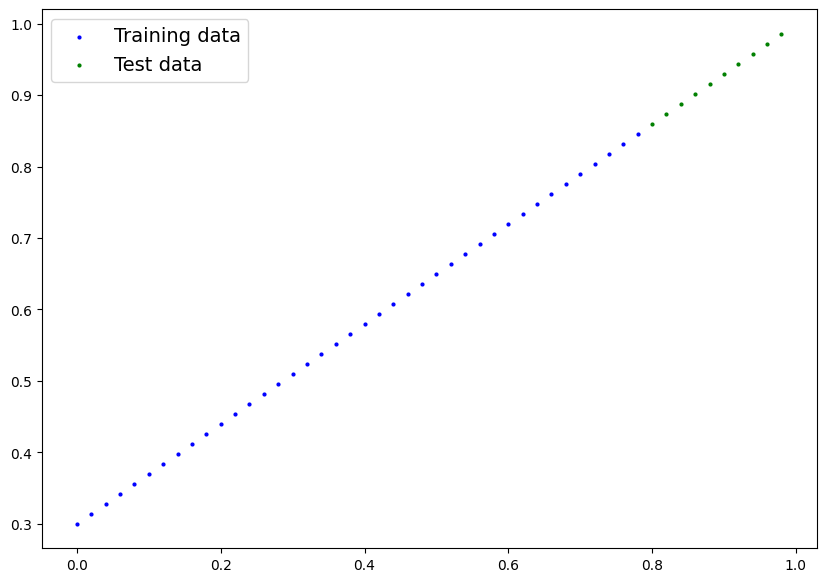

In [6]:
plot_predictions()

## 2. Build model

In [7]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1,
                                                requires_grad=True,
                                                dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1,
                                             requires_grad=True,
                                             dtype=torch.float))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

In [8]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [9]:
with torch.inference_mode():
    y_preds = model_0(X_test)

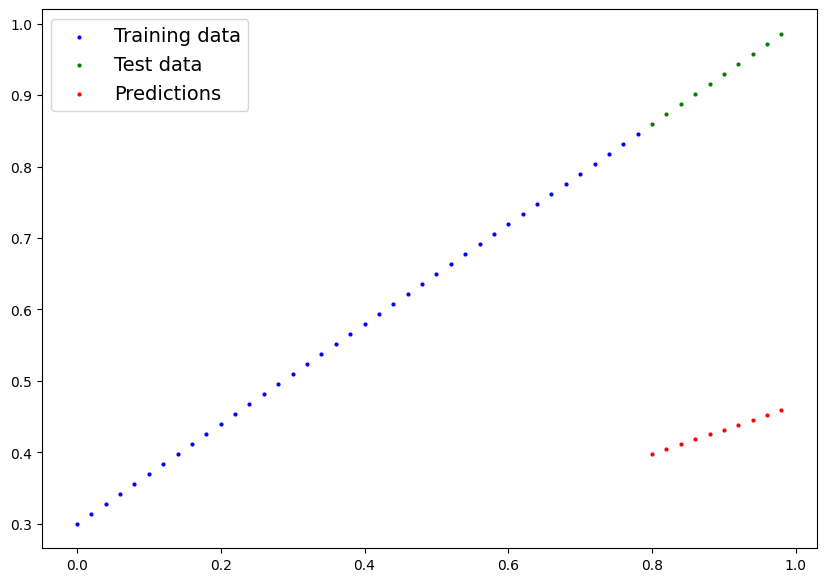

In [10]:
plot_predictions(predictions=y_preds)

## 3. Train model

In [11]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup a optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

### Building a training loop (and a testing loop) in PyTorch

In [12]:
epochs = 200

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

for epoch in range(epochs):
    # Set the model to training mode
    model_0.train()

    y_pred = model_0(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    model_0.eval()
    with torch.inference_mode():
        test_pred = model_0(X_test)
        test_loss = loss_fn(test_pred, y_test)
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
        print(model_0.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict({'weights': tensor([0.3406]), 'bias': tensor([0.1388])})
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict({'weights': tensor([0.3796]), 'bias': tensor([0.2388])})
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict({'weights': tensor([0.4184]), 'bias': tensor([0.3333])})
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict({'weights': tensor([0.4512]), 'bias': tensor([0.3768])})
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict({'weights': tensor([0.4748]), 'bias': tensor([0.3868])})
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict({'weights': tensor([0.4938]), 'bias': tensor([0.3843])})
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict({'weights': tensor([0.5116]), 'bias': tensor([0.3788])})
Epoch: 70 | Loss: 0.03

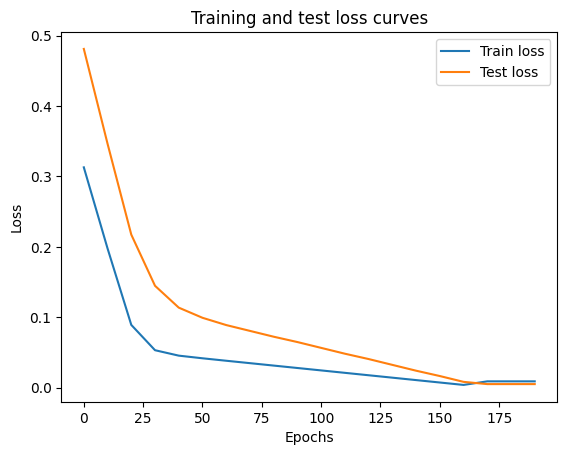

In [13]:
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).numpy()), label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [14]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

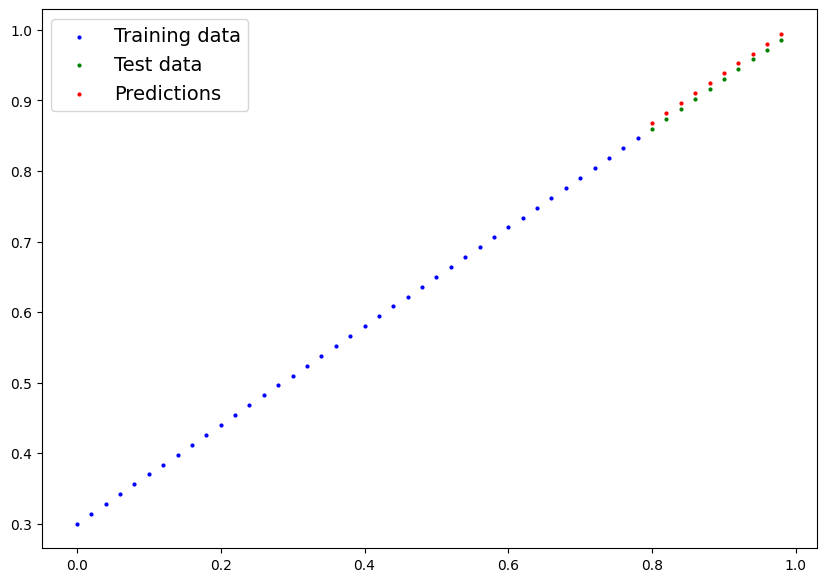

In [15]:
plot_predictions(predictions=y_preds_new)

## Saving a model in PyTorch

In [17]:
# Saving our PyTorch model
from pathlib import Path

MODEL_PATH = Path("./models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models\01_pytorch_workflow_model_0.pth


## Loading a PyTorch model

In [23]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [24]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0 (this will update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

C:\Users\MONSTER\AppData\Local\Temp\ipykernel_8240\1170343677.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH

<All keys matched successfully>

In [25]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])